In [1]:
import warnings
warnings.filterwarnings('ignore')

# Lab 10 - Linear Models - Solution

In [2]:
% matplotlib inline

## Directions

**Failure to follow the directions will result in a "0"**

The due dates for each are indicated in the Syllabus and the course calendar. If anything is unclear, please email EN605.448@gmail.com the official email for the course or ask questions in the Lab discussion area on Blackboard.

The Labs also present technical material that augments the lectures and "book".  You should read through the entire lab at the start of each module.

### General Instructions

1.  You will be submitting your assignment to Blackboard. If there are no accompanying files, you should submit *only* your notebook and it should be named using *only* your JHED id: fsmith79.ipynb for example if your JHED id were "fsmith79". If the assignment requires additional files, you should name the *folder/directory* your JHED id and put all items in that folder/directory, ZIP it up (only ZIP...no other compression), and submit it to Blackboard.
    
    * do **not** use absolute paths in your notebooks. All resources should appear in the same directory as the rest of your assignments.
    * the directory **must** be named your JHED id and **only** your JHED id.
    
2. Data Science is as much about what you write (communicating) as the code you execute (researching). In many places, you will be required to execute code and discuss both the purpose and the result. Additionally, Data Science is about reproducibility and transparency. This includes good communication with your team and possibly with yourself. Therefore, you must show **all** work.

3. Avail yourself of the Markdown/Codecell nature of the notebook. If you don't know about Markdown, look it up. Your notebooks should not look like ransom notes. Don't make everything bold. Clearly indicate what question you are answering.

4. Submit a cleanly executed notebook. It should say `In [1]` for the first codecell and increase by 1 throughout.

## Linear Regression

In a previous module (Lab 5), you performed EDA on the insurance data set. In this Lab, you should build a linear regression model trying to estimate `charges`.

In [3]:
import numpy as np
import random as py_random
import numpy.random as np_random
import time
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats

sns.set(style="whitegrid")

# Answer

(Obviously, this is not *the* solution but a possible solution.)

Let's review the EDA from Lab 5. What did we learn?

The data contains a number of variables. We have age, sex, BMI, number of children, smoking, region, and the target variable, charges.

* Age - Uniform distribution
* Sex - Bernoulli distribution, 50/50
* BMI - Normal distribution
* Children - Multinomial distribution, possibly geometric.
* Smoking - Bernoulli distribution, 20/80
* Region - Multinomial distribution
* Charges - Exponential distribution-ish (no zero charges).

For the features, there's nothing that particularly stands out as needing our attention. Sex and smoker will need to be converted into a dummy variable and Region will need to be converted into four dummy variables. Let's load the data:

In [4]:
insurance = pd.read_csv( "insurance.csv", header=0)

In [5]:
insurance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
age         1338 non-null int64
sex         1338 non-null object
bmi         1338 non-null float64
children    1338 non-null int64
smoker      1338 non-null object
region      1338 non-null object
charges     1338 non-null float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.2+ KB


#### We noted in our EDA that `charges` is not normally distributed. This may cause problems later but let's leave it for now.

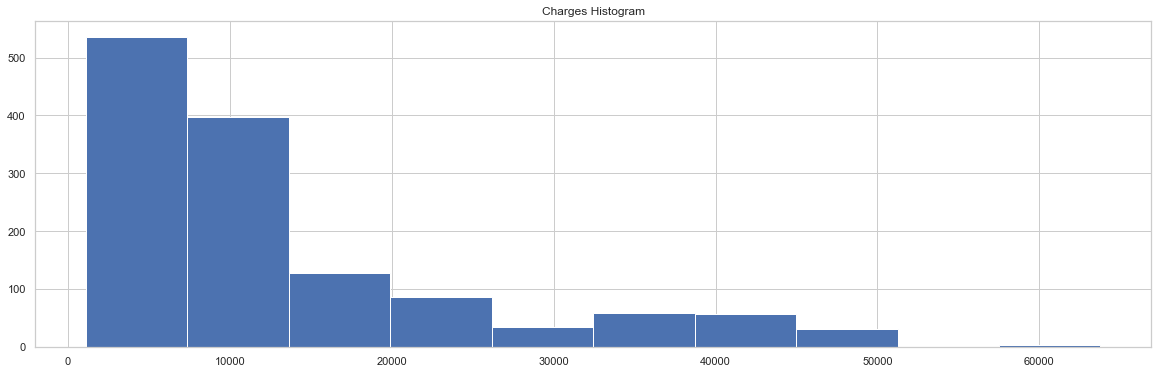

In [6]:
figure = plt.figure(figsize=(20,6))
axes = figure.add_subplot(1,1,1)
axes.hist(insurance.charges)
axes.set_title("Charges Histogram")
plt.show()
plt.close()    

Let's review our pairwise EDA with the target variable, charges:

* age - definite positive progression but banding suggests an interaction term.
* sex - possibly some higher charges for men.
* BMI - overall positive but banding suggests there are other factors.
* smoking - definitely a relationship.

We didn't look at children but the connection doesn't seem likely to be strong on the face of it.

Since we've decided to use a linear model, it is much more important to look at the correlation coefficients between each variable and the target, and each other but first we need those dummy variables:

In [7]:
insurance = pd.concat([insurance, pd.get_dummies(insurance["sex"])], axis=1)
insurance = pd.concat([insurance, pd.get_dummies(insurance["region"])], axis=1)
insurance = pd.concat([insurance, pd.get_dummies(insurance["smoker"], prefix="smoke")], axis=1)

In [8]:
insurance.head()

,age,sex,bmi,children,smoker,region,charges,female,male,northeast,northwest,southeast,southwest,smoke_no,smoke_yes
0,19,female,27.900,0,yes,southwest,16884.92400,1,0,0,0,0,1,0,1
1,18,male,33.770,1,no,southeast,1725.55230,0,1,0,0,1,0,1,0
2,28,male,33.000,3,no,southeast,4449.46200,0,1,0,0,1,0,1,0
3,33,male,22.705,0,no,northwest,21984.47061,0,1,0,1,0,0,1,0
4,32,male,28.880,0,no,northwest,3866.85520,0,1,0,1,0,0,1,0


And now we can calculate our correlation coefficients:

In [9]:
def correlations(data, y, xs):
    rs = []
    rhos = []
    for x in xs:
        r = stats.pearsonr(data[y], data[x])[0]
        rs.append(r)
        rho = stats.spearmanr(data[y], data[x])[0]
        rhos.append(rho)
    return pd.DataFrame({"feature": xs, "r": rs, "rho": rhos})

In [10]:
correlations(insurance, "charges", ["age", "male", "female", 
                                    "bmi", "smoke_yes", "children", 
                                    "northwest", "southwest", "southeast"])

,feature,r,rho
0,age,0.299008,0.534392
1,male,0.057292,0.009490
2,female,-0.057292,-0.009490
3,bmi,0.198341,0.119396
4,smoke_yes,0.787251,0.663460
5,children,0.067998,0.133339
6,northwest,-0.039905,-0.021634
7,southwest,-0.043210,-0.042354
8,southeast,0.073982,0.017275


There are some interesting results here:

1. age - as we saw in the EDA, there is a positive relationship (30%) but that Spearman's suggests that the relationship is non-linear.
2. male - not a huge relationship.
3. female - exact same but opposite relationship as `male`. I included it to demonstrate why it's not needed to include both. I'm including the `sex` dummy variable for `male` because our EDA suggested that there was some relationship there.
4. bmi - not a huge relationship and the Spearman doesn't suggest that this is because it's nonlinear.
5. smoking - definite relationship. We already knew this.
6. children - not a huge relationship but the larger Spearman's indicates the relationship might be non-linear.

The `southest` variable looks at least as promising as `male` but we'll hold off on the regional variables for now. There's good reason to believe that for any effect we find, it's likely that regional differences are likely the result of the different distribution of those effects.

Before estimating any linear models, let's look at the Null model (the mean):

In [11]:
insurance.charges.describe()

count     1338.000000
mean     13270.422265
std      12110.011237
min       1121.873900
25%       4740.287150
50%       9382.033000
75%      16639.912515
max      63770.428010
Name: charges, dtype: float64

The lowest charge is \$1,121 and the highest is \$63,770. The mean is \$13,270 with a standard deviation of \$12,110. You can think of \$12,110 as the $\sigma$ of the Null model.

(This is somewhat artificial...modeling like this is likely to follow directly after the EDA)

Let's try the "all in" model. We have domain knowledge and some statistics to support the inclusion of all the variables (exception regions):

In [12]:
import models

In [13]:
model = "charges ~ age + male + bmi + smoke_yes + children"
result1 = models.bootstrap_linear_regression(model, data=insurance)
models.describe_bootstrap_lr(result1)

The correlation coefficient is 75% which is pretty good. The error has been cut in half compared to the Null model to \$6,070. But we have already seen that `charges` is not Normally distributed so the overall error is probably not good to use. What about coefficients:

* The intercept isn't particularly interesting here because there are no childless, non-smoking females with zero age and BMI. 
* age is positive and strongly supported by the data.
* male is negative (suprise!) and has mixed support in the data.
* bmi is positive and strongly supported by the data.
* smoke_yes is positive and strongly supported by the data.
* children is positive (surprise!) and strongly supported by the data.

With our first model done, here's what we think we know:

1. Charges is not normally distributed so a transformation is probably in order.
2. We could improve interpretability if we mean centered and possibly mean scaled the data.
3. male and children are surprises and it's not clear why for now.

Let's look at the residuals:


In [14]:
def plot_residuals(result, variables):
    figure = plt.figure(figsize=(20,6))

    variables = ["age", "bmi", "children"]

    plots = len( variables)
    rows = (plots // 3) + 1

    residuals = np.array([r[0] for r in result["residuals"]])
    limits = max(np.abs(residuals.min()), residuals.max())
    
    n = result["n"]
    for i, variable in enumerate( variables):
        axes = figure.add_subplot(rows, 3, i + 1)

        keyed_values = sorted(zip(insurance[variable].values, residuals), key=lambda x: x[ 0])
        ordered_residuals = [x[ 1] for x in keyed_values]

        axes.plot(list(range(0, n)), ordered_residuals, '.', color="dimgray", alpha=0.75)
        axes.axhline(y=0.0, xmin=0, xmax=n, c="firebrick", alpha=0.5)
        axes.set_ylim((-limits, limits))
        axes.set_ylabel("residuals")
        axes.set_xlabel(variable)

    plt.show()
    plt.close()
    
    return residuals

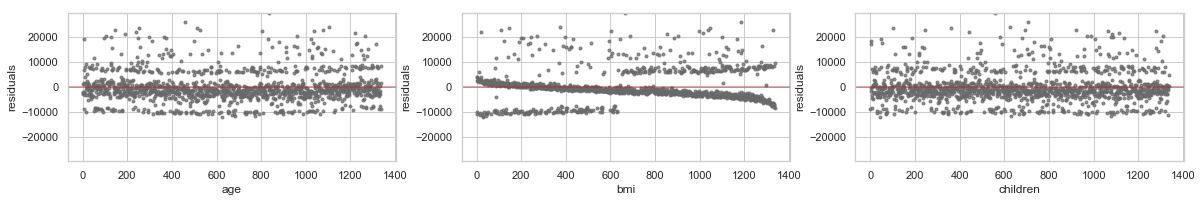

In [58]:
residuals1 = plot_residuals(result1, ["age", "bmi", "children"])

This is very interesting.

For age, we see three bands. We saw these bands in our EDA. They basically say, at every age, there is some information you are missing that is causing you to be systematically wrong. But they are also slightly curved in a way that suggests increasing returns just like in our discussion of residuals. Additionally, the errors are not symmetric. For every age, we are more likely to overestimate charges.

We see the same banding for children and the same systematic over estimation.

The most interesting result is for BMI. First, the middle band has an inflection that suggests a non-linearity. Second, there's an abrupt break in the error just over the 600th observation. Additionally, if you connected the those two lines, it suggests that you'd have the opposite inflection as the middle line.

We mentioned before that charges is not normally distributed and that this might cause some problems. Let's see if we can address that issue.

In [16]:
insurance["log_charges"] = insurance["charges"].apply(np.log)

Let's see a histogram:

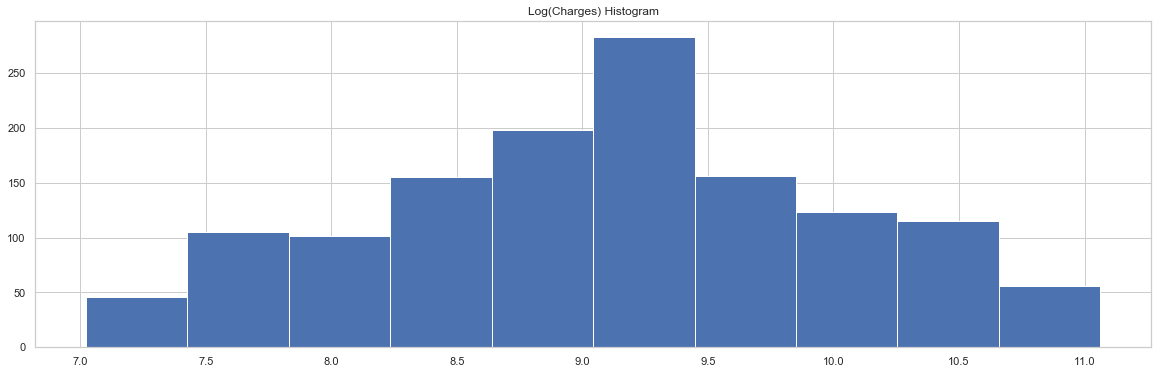

In [17]:
figure = plt.figure(figsize=(20,6))
axes = figure.add_subplot(1,1,1)
axes.hist(insurance.log_charges)
axes.set_title("Log(Charges) Histogram")
plt.show()
plt.close()

That looks better than before. It's not exactly normal but is fairly symmetric. Let's try to use this as our response variable:

In [18]:
model = "log_charges ~ age + male + bmi + smoke_yes + children"
result2 = models.bootstrap_linear_regression(model, data=insurance)
models.describe_bootstrap_lr(result2)

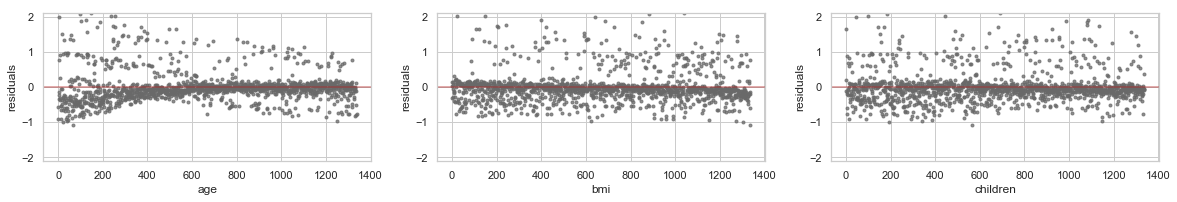

In [19]:
residuals2 = plot_residuals(result2, ["age", "bmi", "children"])

Where did all the bands go? This doesn't look very symmetric either. I think we need to compare the histograms of charges versus residuals:

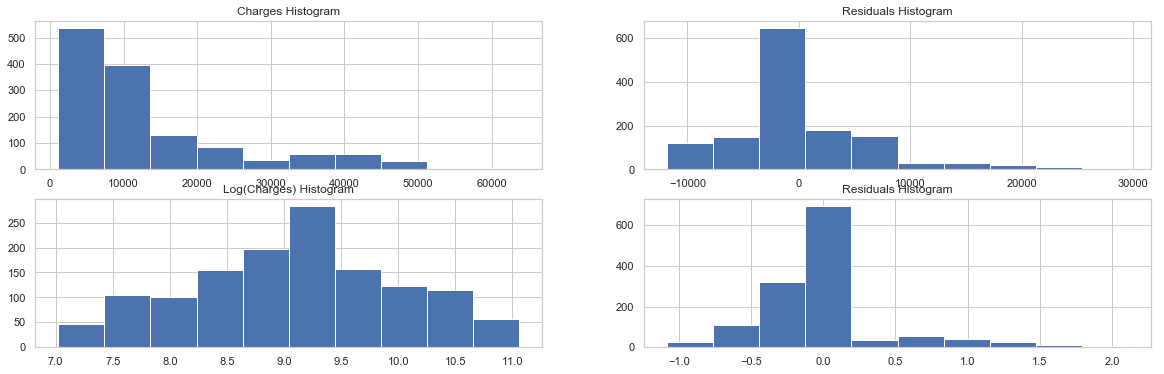

In [20]:
figure = plt.figure(figsize=(20,6))

axes = figure.add_subplot(2, 2, 1)
axes.hist(insurance.charges)
axes.set_title("Charges Histogram")

axes = figure.add_subplot(2, 2, 2)
axes.hist(residuals1)
axes.set_title("Residuals Histogram")

axes = figure.add_subplot(2, 2, 3)
axes.hist(insurance.log_charges)
axes.set_title("Log(Charges) Histogram")

axes = figure.add_subplot(2, 2, 4)
axes.hist(residuals2)
axes.set_title("Residuals Histogram")

plt.show()
plt.close()    

Interesting indeed. Our errors are much more symmetric with the actual charges variable rather than the transformed charges variable.

This is a key point that is often misunderstood or even misstated: linear regression does not require your variables to be normally distributed. We only expect normally distributed *errors* (residuals) and then only for gauging the confidence in our estimates. Lacking such normality, we can easily fall back on Bootstrap estimates.

Let's continue with the untransformed charges variable...

Unlike many such situations, there are no variables we haven't added to the data so we're left with:

1. transforms
2. interaction terms.

We have some ideas for transforms so let's start there. Age looks like it should be squared. This basically means that as you age, charges increase *and at an increasing amount*. Let's see if that's true:

In [21]:
insurance["age_sq"] = insurance.age**2

In [22]:
model = "charges ~ age_sq + male + bmi + smoke_yes + children"
result3 = models.bootstrap_linear_regression(model, data=insurance)
models.describe_bootstrap_lr(result3)

That didn't change the $R^2$ what about the residuals?

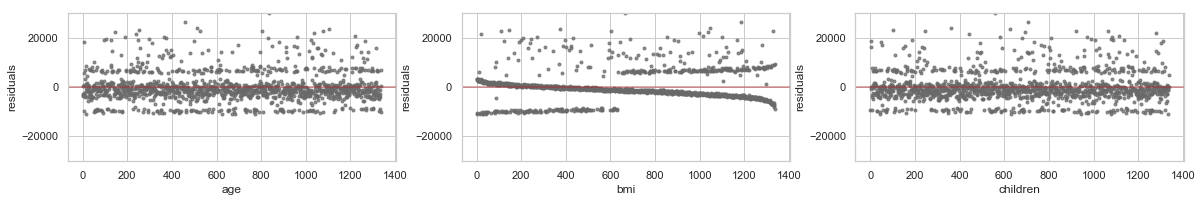

In [23]:
residuals3 = plot_residuals(result3, ["age_sq", "bmi", "children"])

For comparison,

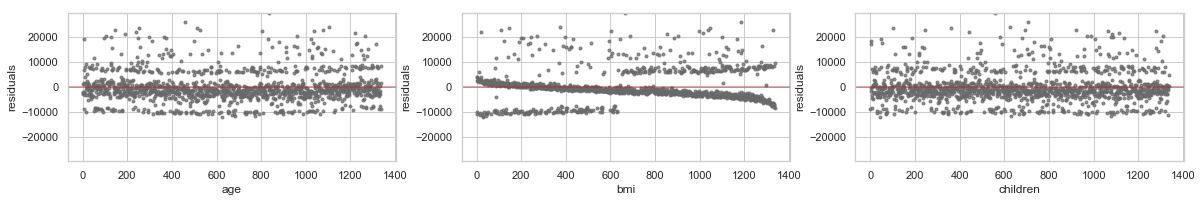

In [24]:
plot_residuals(result1, ["age", "bmi", "children"]); # the semicolon suppresses printing out the result.

So the curves in *age* are gone, the error ($\sigma$) went down *slightly* but the artifacts on BMI are less disperse with the new model. Let's see if we can fix that. What if there are decreasing returns to BMI?

In [25]:
insurance["bmi_sqrt"] = insurance.bmi.apply(np.sqrt)

In [26]:
model = "charges ~ age_sq + male + bmi_sqrt + smoke_yes + children"
result4 = models.bootstrap_linear_regression(model, data=insurance)
models.describe_bootstrap_lr(result4)

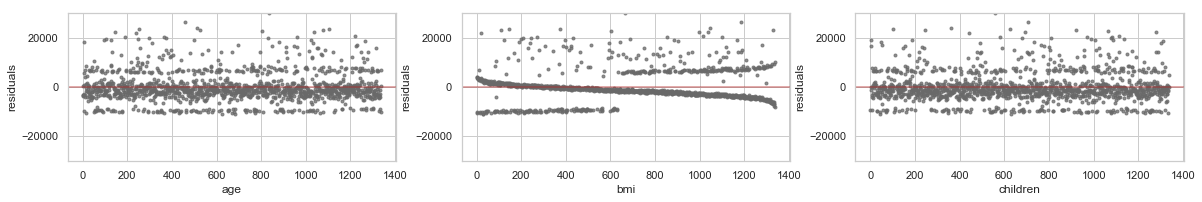

In [27]:
residuals4 = plot_residuals(result4, ["age", "bmi", "children"])

Doesn't look like it...squared?

In [28]:
insurance["bmi_sq"] = insurance.bmi**2

In [29]:
model = "charges ~ age_sq + male + bmi_sq + smoke_yes + children"
result5 = models.bootstrap_linear_regression(model, data=insurance)
models.describe_bootstrap_lr(result5)

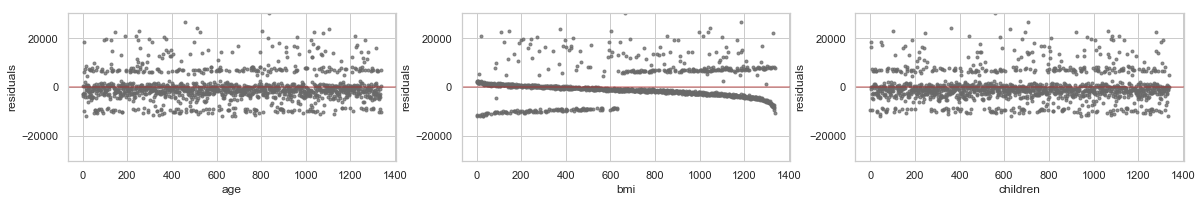

In [30]:
residuals5 = plot_residuals(result5, ["age", "bmi", "children"])

We don't seem to be making much progress here. There's a non-linearity but we can't identify it. Let's switch for a bit and think of *interaction* terms.

There are a lot of potential interaction terms: male, age, bmi, smoke_yes, but we only have 1,336 observations so we can't get overly specific. Let's try the big one: male and bmi.

In [31]:
model = "charges ~ age_sq + male + bmi + male:bmi + smoke_yes + children"
result6 = models.bootstrap_linear_regression(model, data=insurance)
models.describe_bootstrap_lr(result6)

Wow, that seemed like a slam dunk but the $R^2$ didn't even move. Smoking and bmi?

In [32]:
model = "charges ~ age_sq + male + bmi + smoke_yes + smoke_yes:bmi + children"
result7 = models.bootstrap_linear_regression(model, data=insurance)
models.describe_bootstrap_lr(result7)

The $R^2$ went up a lot but what about the *adjusted* $R^2$?

In [33]:
print(models.adjusted_r_squared(result1))
print(models.adjusted_r_squared(result6))

0.7484052599228702
0.7509684533349236


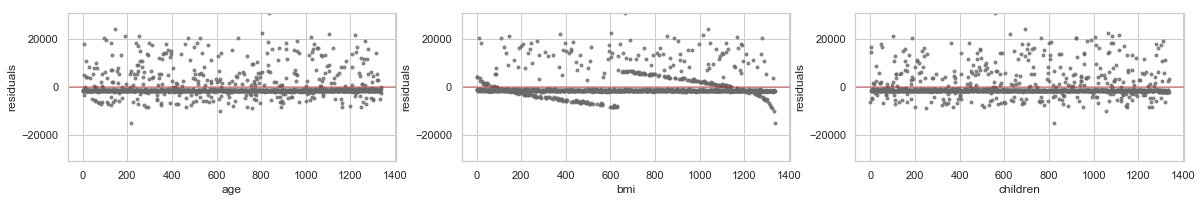

In [34]:
residuals7 = plot_residuals(result7, ["age", "bmi", "children"])

So that took care of a *whole* lot of our error. It shifted the residuals all around but we still have a break in the BMI. Are the residuals correlated with anything?

In [35]:
insurance["residuals"] = residuals7

In [36]:
correlations(insurance, "residuals", ["northeast", "southeast", "southwest"])

,feature,r,rho
0,northeast,0.087398,0.424320
1,southeast,-0.048958,-0.279556
2,southwest,-0.053899,-0.263691


Hmm, maybe there are real regional differences in health! Let's add these into the regression:

In [37]:
model = "charges ~ age_sq + male + bmi + smoke_yes + smoke_yes:bmi + children + northeast + southwest + southeast"
result8 = models.bootstrap_linear_regression(model, data=insurance)
models.describe_bootstrap_lr(result8)

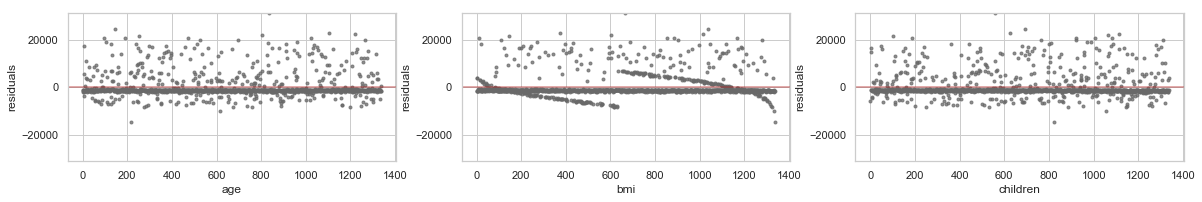

In [38]:
residuals8 = plot_residuals(result8, ["age", "bmi", "children"])

The error goes down a *little* and it appears that those in the Southwest are slightly healthier for some reason. The evidence is pretty strong for the northeast having higher charges and for the southeast having lower charges...which sort of defies stereotypes. There may be something else going on here so let's continue to leave the regional dummy variables out.

Let's look at the actual data. First we need to figure out the actual BMI associated with those indices. We can do this by replotting with BMI on the axis instead of index:

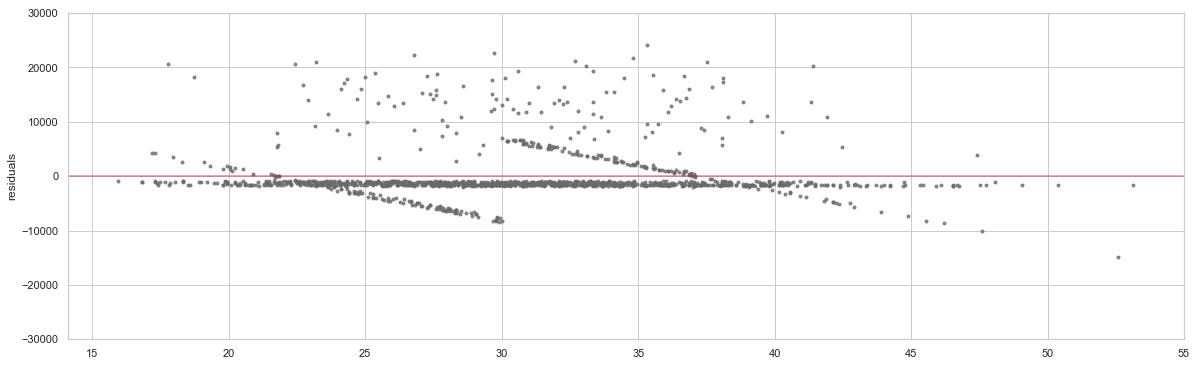

In [39]:
n = result7["n"]

figure = plt.figure(figsize=(20,6))

axes = figure.add_subplot(1, 1, 1)

keyed_values = sorted(zip(insurance.bmi.values, insurance.residuals), key=lambda x: x[ 0])
ordered_residuals = [x[ 1] for x in keyed_values]
bmi_values = [x[0] for x in keyed_values]

axes.plot(bmi_values, ordered_residuals, '.', color="dimgray", alpha=0.75)
axes.axhline(y=0.0, xmin=0, xmax=n, c="firebrick", alpha=0.5)
axes.set_ylim((-30000, 30000))
axes.set_ylabel("residuals")

plt.show()
plt.close()

Notice how we can't see the curvature when plotted as BMI because of overstriking. Still, with this plot, we can see that our problem happens almost exactly at BMI=30. Since we put residuals into the dataframe, we can do a bit of filtering. What happens if we take out women?

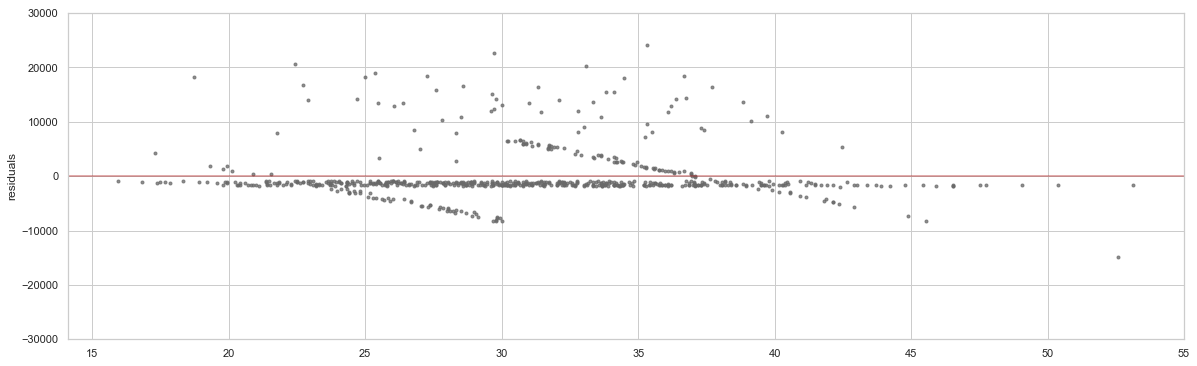

In [40]:
subset = insurance[insurance.male == 1]
n = len(subset.index)

figure = plt.figure(figsize=(20,6))

axes = figure.add_subplot(1, 1, 1)

keyed_values = sorted(zip(subset.bmi.values, subset.residuals), key=lambda x: x[ 0])
ordered_residuals = [x[ 1] for x in keyed_values]
bmi_values = [x[0] for x in keyed_values]

axes.plot(bmi_values, ordered_residuals, '.', color="dimgray", alpha=0.75)
axes.axhline(y=0.0, xmin=0, xmax=n, c="firebrick", alpha=0.5)
axes.set_ylim((-30000, 30000))
axes.set_ylabel("residuals")

plt.show()
plt.close()

Is it only men?

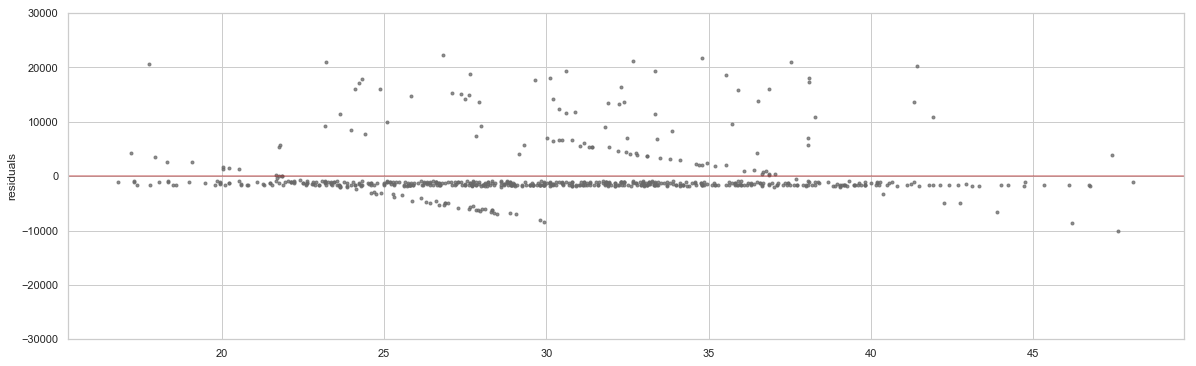

In [41]:
subset = insurance[insurance.male == 0]
n = len(subset.index)

figure = plt.figure(figsize=(20,6))

axes = figure.add_subplot(1, 1, 1)

keyed_values = sorted(zip(subset.bmi.values, subset.residuals), key=lambda x: x[ 0])
ordered_residuals = [x[ 1] for x in keyed_values]
bmi_values = [x[0] for x in keyed_values]

axes.plot(bmi_values, ordered_residuals, '.', color="dimgray", alpha=0.75)
axes.axhline(y=0.0, xmin=0, xmax=n, c="firebrick", alpha=0.5)
axes.set_ylim((-30000, 30000))
axes.set_ylabel("residuals")

plt.show()
plt.close()

Nope, still there. What about smoking?

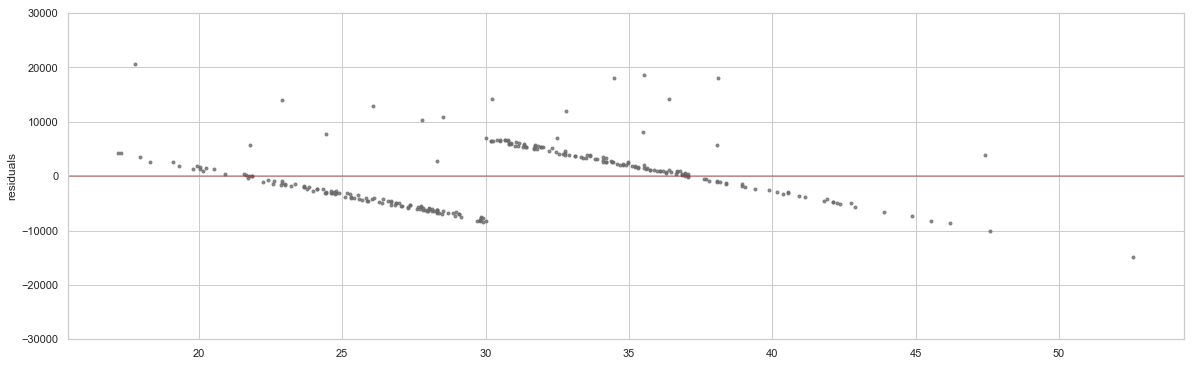

In [42]:
subset = insurance[insurance.smoke_yes == 1]
n = len(subset.index)

figure = plt.figure(figsize=(20,6))

axes = figure.add_subplot(1, 1, 1)

keyed_values = sorted(zip(subset.bmi.values, subset.residuals), key=lambda x: x[ 0])
ordered_residuals = [x[ 1] for x in keyed_values]
bmi_values = [x[0] for x in keyed_values]

axes.plot(bmi_values, ordered_residuals, '.', color="dimgray", alpha=0.75)
axes.axhline(y=0.0, xmin=0, xmax=n, c="firebrick", alpha=0.5)
axes.set_ylim((-30000, 30000))
axes.set_ylabel("residuals")

plt.show()
plt.close()

Interesting. What about non-smoking?

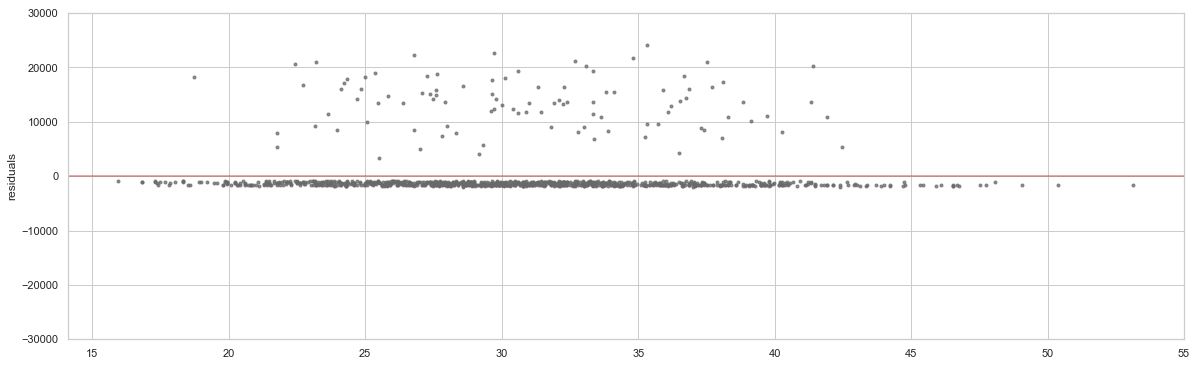

In [43]:
subset = insurance[insurance.smoke_yes == 0]
n = len(subset.index)

figure = plt.figure(figsize=(20,6))

axes = figure.add_subplot(1, 1, 1)

keyed_values = sorted(zip(subset.bmi.values, subset.residuals), key=lambda x: x[ 0])
ordered_residuals = [x[ 1] for x in keyed_values]
bmi_values = [x[0] for x in keyed_values]

axes.plot(bmi_values, ordered_residuals, '.', color="dimgray", alpha=0.75)
axes.axhline(y=0.0, xmin=0, xmax=n, c="firebrick", alpha=0.5)
axes.set_ylim((-30000, 30000))
axes.set_ylabel("residuals")

plt.show()
plt.close()

Well, there are still problems but not *this* problem. Whatever "this" is, it happens only to smokers, still, it's an incredibly strange discontinuity. Whatever "it" is, we over then underestimate charges until BMI 30...and exactly at BMI 30, it shifts to over estimating and underestimating again.

Let's look at the data:

In [44]:
pd.options.display.max_rows = 100

In [45]:
by_bmi = insurance.sort_values(by="bmi")

In [46]:
data = by_bmi[by_bmi.smoke_yes == 1][((28 <= by_bmi.bmi) & (by_bmi.bmi <= 32))]
data[["age", "male", "bmi", "children", "region", "charges", "residuals"]]

/Users/wangyan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,age,male,bmi,children,region,charges,residuals
52,48,1,28.000,1,southwest,23568.27200,-6394.900885
827,36,1,28.025,1,northeast,20773.62775,-5854.268234
105,20,1,28.025,1,northwest,17560.37975,-6070.813774
1040,35,0,28.025,0,northwest,20234.85475,-6002.302697
280,40,0,28.120,1,northeast,22331.56680,-5950.484142
1307,32,1,28.120,4,northwest,21472.47880,-6344.082100
1007,47,1,28.215,3,northwest,24915.22085,-6347.621165
514,39,1,28.300,1,southwest,21082.16000,-6694.403153
126,19,0,28.300,0,southwest,17081.08000,-6662.547096
375,23,0,28.310,0,northwest,18033.96790,-6285.946253


We can see the break exactly at $BMI=30$. It seems incredibly strange that diseases just magically know that your BMI is over 30 *and* you smoke and therefore you get more of them and your healthcare charges go up. 

Could it be as simple as the insurance company is just plain charging more for smokers with a high BMI? Let's create a dummy variable:

In [47]:
insurance["bmi_above_30"] = insurance.bmi.apply(lambda bmi: 1 if bmi > 30.0 else 0)

In [48]:
model = "charges ~ age_sq + male + bmi + smoke_yes + smoke_yes:bmi + children + bmi_above_30"
result9 = models.bootstrap_linear_regression(model, data=insurance)
models.describe_bootstrap_lr(result9)

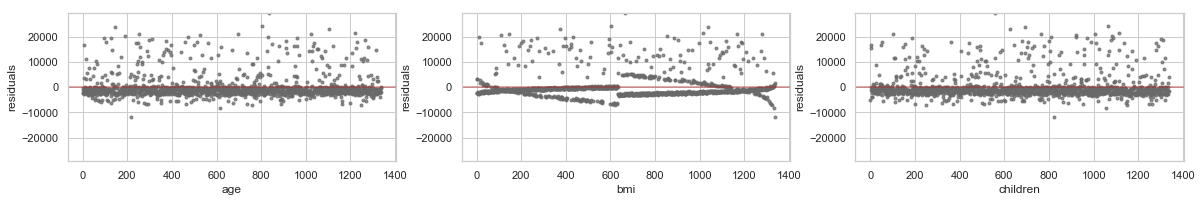

In [49]:
residuals9 = plot_residuals(result9, ["age", "bmi", "children"])

This just breaks up both "bands. We did observe that this only happens to smokers. Let's change this to an interactin term with smoke_yes:

In [50]:
model = "charges ~ age_sq + male + bmi + smoke_yes + smoke_yes:bmi + children + smoke_yes:bmi_above_30"
result10 = models.bootstrap_linear_regression(model, data=insurance)
models.describe_bootstrap_lr(result10)

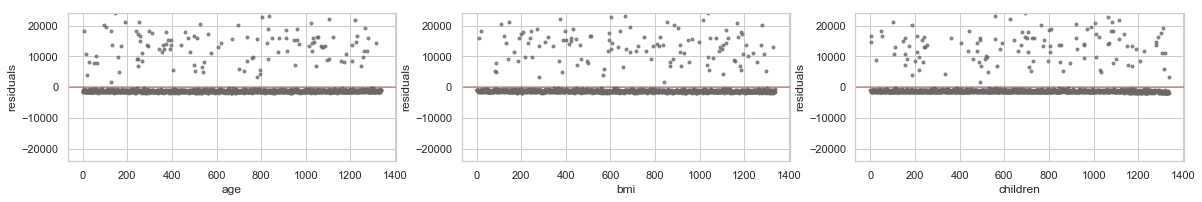

In [51]:
residuals10 = plot_residuals(result10, ["age", "bmi", "children"])

Wow, that seems to be the case. Now we get all kinds of interesting things falling out of the model.

1. age is positive; this is expected.
2. male is *negative*; if you correct for BMI and smoking, you're not getting charged more for being male.
3. bmi *by itself* doesn't seem to have strong evidence to support it in terms of a score. Maybe charges aren't a good proxy for disease?
4. smoke_yes *by itself* doesn't seem to have a strong effect on charges.
5. smoking_yes *and* bmi have a positive effect on charges.
6. children is positive and has strong support from the data.
7. smoking and a bmi above 30 have a base effect on charges.

Thinking just about smoking and BMI. Neither seems to have a strong effect on *charges* alone. However, together both set a higher base rate of charges and as BMI increases (while smoking) charges increase.

I'm not sure what this says about disease v. charges. What about the children? It seems like this would affect women more than men. Let's make it an interaction term:

In [52]:
model = "charges ~ age_sq + male + bmi + smoke_yes + smoke_yes:bmi + male:children + smoke_yes:bmi_above_30"
result11 = models.bootstrap_linear_regression(model, data=insurance)
models.describe_bootstrap_lr(result11)

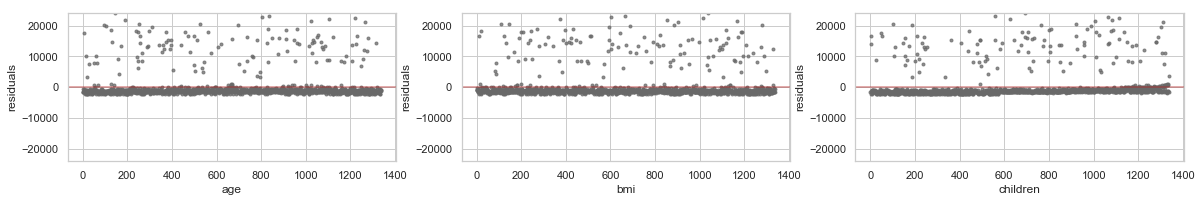

In [53]:
residuals11 = plot_residuals(result11, ["age", "bmi", "children"])

That's strange. The intercept is positive. If you're male, charges go down but if you're a male with *children* charges go back up. We might need both children and the interaction term:

In [54]:
model = "charges ~ age_sq + male + bmi + smoke_yes + smoke_yes:bmi + smoke_yes:bmi_above_30 + children + male:children"
result12 = models.bootstrap_linear_regression(model, data=insurance)
models.describe_bootstrap_lr(result12)

Nope, that doesn't seem to help. It looks like having children affects both men's and women's charges. Our "final model is:

In [55]:
model = "charges ~ age_sq + male + bmi + smoke_yes + smoke_yes:bmi + smoke_yes:bmi_above_30 + children"
final = models.bootstrap_linear_regression(model, data=insurance)
models.describe_bootstrap_lr(final)

We know we *can* produce estimates using the Bootstrap but do we *have* to? Looking at the individual residuals, we can see that we do:

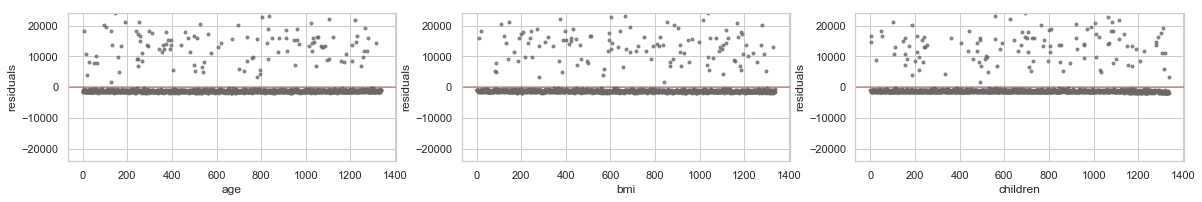

In [56]:
residuals_final= plot_residuals(final, ["age", "bmi", "children"])

These sorts of patterns are typical with targets that can't be negative. There's no place for the other side of the tail to be (or it's just all truncated at "no charges"). Although we didn't do it before, we can also just plot a histogram of residuals:

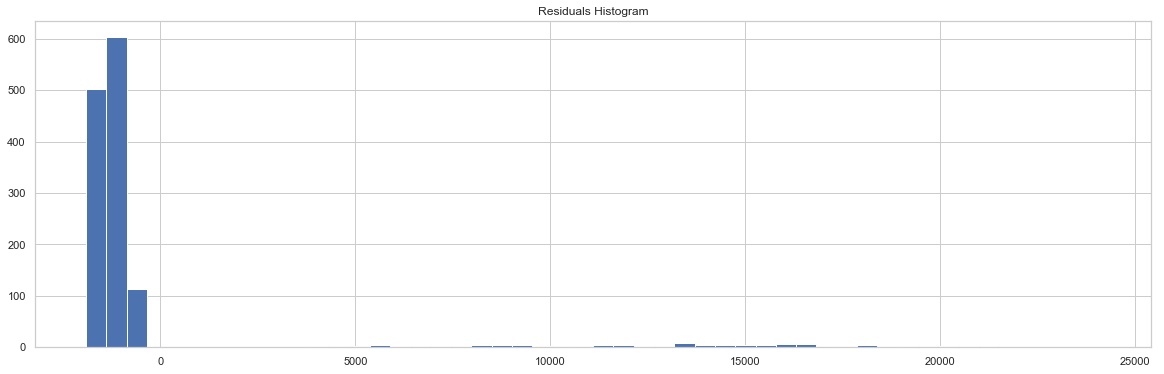

In [57]:
figure = plt.figure(figsize=(20,6))
axes = figure.add_subplot(1,1,1)
axes.hist(residuals_final, bins=50)
axes.set_title("Residuals Histogram")
plt.show()
plt.close()  

There might be some other analysis we can do but this appears to be the bulk of it. The $R^2$ is pretty high...87%. All the variables in the model make sense. I'm not sure what our model turned out to be a model *of*...which goes to validity. You can't use charge data to make a model of disease.